In [ ]:
!pip install catboost
!pip install lightgbm --install-option=--gpu

     |████████████████████████████████| 67.3MB 41kB/s 
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [ ]:
import argparse
import sys
import time
import os

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve  # pylint: disable=import-error,no-name-in-module
else:
    from urllib import urlretrieve  # pylint: disable=import-error,no-name-in-module

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# Global parameters
random_seed = 0
max_depth = 6
learning_rate = 0.1
min_split_loss = 0
min_weight = 1
l1_reg = 0
l2_reg = 1

# Dataset Importing Functions

In [ ]:
import os
import sys
import tarfile

import numpy as np
import pandas as pd
from sklearn import datasets
from joblib.memory import Memory

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve  # pylint: disable=import-error,no-name-in-module
else:
    from urllib import urlretrieve  # pylint: disable=import-error,no-name-in-module

mem = Memory("./mycache")

get_airline_url = 'http://kt.ijs.si/elena_ikonomovska/datasets/airline/airline_14col.data.bz2'


@mem.cache
def get_airline(num_rows=None):
    """
    Airline dataset (http://kt.ijs.si/elena_ikonomovska/data.html)
    Has categorical columns converted to ordinal and target variable "Arrival Delay" converted
    to binary target.
    - Dimensions: 115M rows, 13 columns.
    - Task: Binary classification
    :param num_rows:
    :return: X, y
    """
    filename = 'airline_14col.data.bz2'
    if not os.path.isfile(filename):
        urlretrieve(get_airline_url, filename)

    cols = [
        "Year", "Month", "DayofMonth", "DayofWeek", "CRSDepTime",
        "CRSArrTime", "UniqueCarrier", "FlightNum", "ActualElapsedTime",
        "Origin", "Dest", "Distance", "Diverted", "ArrDelay"
    ]

    # load the data as int16
    dtype = np.int16

    dtype_columns = {
        "Year": dtype, "Month": dtype, "DayofMonth": dtype, "DayofWeek": dtype,
        "CRSDepTime": dtype, "CRSArrTime": dtype, "FlightNum": dtype,
        "ActualElapsedTime": dtype, "Distance":
            dtype,
        "Diverted": dtype, "ArrDelay": dtype,
    }

    df = pd.read_csv(filename,
                     names=cols, dtype=dtype_columns, nrows=num_rows)

    # Encode categoricals as numeric
    for col in df.select_dtypes(['object']).columns:
        df[col] = df[col].astype("category").cat.codes

    # Turn into binary classification problem
    df["ArrDelayBinary"] = 1 * (df["ArrDelay"] > 0)

    X = df[df.columns.difference(["ArrDelay", "ArrDelayBinary"])]
    y = df["ArrDelayBinary"]

    del df
    return X, y


get_higgs_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'  # pylint: disable=line-too-long


@mem.cache
def get_higgs(num_rows=None):
    """
    Higgs dataset from UCI machine learning repository (
    https://archive.ics.uci.edu/ml/datasets/HIGGS).
    - Dimensions: 11M rows, 28 columns.
    - Task: Binary classification
    :param num_rows:
    :return: X, y
    """
    filename = 'HIGGS.csv.gz'
    if not os.path.isfile(filename):
        urlretrieve(get_higgs_url, filename)
    higgs = pd.read_csv(filename, nrows=num_rows)
    X = higgs.iloc[:, 1:].values
    y = higgs.iloc[:, 0].values

    return X, y


@mem.cache
def get_cover_type(num_rows=None):
    """
    Cover type dataset from UCI machine learning repository (
    https://archive.ics.uci.edu/ml/datasets/covertype).
    y contains 7 unique class labels from 1 to 7 inclusive.
    - Dimensions: 581012 rows, 54 columns.
    - Task: Multiclass classification
    :param num_rows:
    :return: X, y
    """
    data = datasets.fetch_covtype()
    X = data.data
    y = data.target
    if num_rows is not None:
        X = X[0:num_rows]
        y = y[0:num_rows]

    return X, y

# Reduced dataset size from 10M rows to 2M rows due to limited memory
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html
# Can change n_features for different num features
@mem.cache
def get_synthetic_regression(num_rows=None, num_features=None):
    """
    Synthetic regression generator from sklearn (
    http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html).
    - Dimensions: 2000000 rows, 100 columns.
    - Task: Regression
    :param num_rows:
    :return: X, y
    """
    if num_rows is None:
        num_rows = 2000000
    if num_features is None:
        num_features = 100
    return datasets.make_regression(n_samples=num_rows, n_features=num_features, bias=100, noise=1.0, random_state=0)


get_year_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip'  # pylint: disable=line-too-long


@mem.cache
def get_year(num_rows=None):
    """
    YearPredictionMSD dataset from UCI repository (
    https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd)
    - Dimensions: 515345 rows, 90 columns.
    - Task: Regression
    :param num_rows:
    :return: X,y
    """
    filename = 'YearPredictionMSD.txt.zip'
    if not os.path.isfile(filename):
        urlretrieve(get_year_url, filename)

    year = pd.read_csv(filename, header=None, nrows=num_rows)
    X = year.iloc[:, 1:].values
    y = year.iloc[:, 0].values
    return X, y


get_url_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/url/url_svmlight.tar.gz'  # pylint: disable=line-too-long


@mem.cache
def get_url(num_rows=None):
    """
    URL reputation dataset from UCI repository (
    https://archive.ics.uci.edu/ml/datasets/URL+Reputation)
    Extremely sparse classification dataset. X is returned as a scipy sparse matrix.
    - Dimensions: 2396130 rows, 3231961 columns.
    - Task: Classification
    :param num_rows:
    :return: X,y
    """
    from scipy.sparse import vstack
    filename = 'url_svmlight.tar.gz'
    if not os.path.isfile(filename):
        urlretrieve(get_url_url, filename)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()

    num_files = 120
    files = ['url_svmlight/Day{}.svm'.format(day) for day in range(num_files)]
    data = datasets.load_svmlight_files(files)
    X = vstack(data[::2])
    y = np.concatenate(data[1::2])

    y[y < 0.0] = 0.0

    if num_rows is not None:
        X = X[0:num_rows]
        y = y[0:num_rows]

    return X, y


@mem.cache
def get_bosch(num_rows=None):
    """
    Bosch Production Line Performance data set (
    https://www.kaggle.com/c/bosch-production-line-performance)
    Requires Kaggle API and API token (https://github.com/Kaggle/kaggle-api)
    Contains missing values as NaN.
    - Dimensions: 1.184M rows, 968 columns
    - Task: Binary classification
    :param num_rows:
    :return: X,y
    """
    os.system("kaggle competitions download -c bosch-production-line-performance -f "
              "train_numeric.csv.zip -p .")
    X = pd.read_csv("train_numeric.csv.zip", index_col=0, compression='zip', dtype=np.float32,
                    nrows=num_rows)
    y = X.iloc[:, -1]
    X.drop(X.columns[-1], axis=1, inplace=True)
    return X, y

# Util functions/classes

In [ ]:
class Data:
    def __init__(self, X, y, name, task, metric, train_size=0.6, validation_size=0.2,
                 test_size=0.2):
        assert (train_size + validation_size + test_size) == 1.0
        self.name = name
        self.task = task
        self.metric = metric
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y,
                                                                                test_size=test_size,
                                                                                random_state=random_seed)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train,
                                                                              self.y_train,
                                                                              test_size=validation_size / (1 - test_size),
                                                                              random_state=random_seed)

        assert (self.X_train.shape[0] + self.X_val.shape[0] + self.X_test.shape[0]) == X.shape[0]


def eval(data, pred):
    if data.metric == "RMSE":
        return np.sqrt(mean_squared_error(data.y_test, pred))
    elif data.metric == "Accuracy":
        # Threshold prediction if binary classification
        if data.task == "Classification":
            pred = pred > 0.5
        elif data.task == "Multiclass classification":
            if pred.ndim > 1:
                pred = np.argmax(pred, axis=1)
        return accuracy_score(data.y_test, pred)
    else:
        raise ValueError("Unknown metric: " + data.metric)


def add_data(df, algorithm, data, elapsed, metric):
    time_col = (data.name, 'Time(s)')
    metric_col = (data.name, data.metric)
    try:
        df.insert(len(df.columns), time_col, '-')
        df.insert(len(df.columns), metric_col, '-')
    except:
        pass

    df.at[algorithm, time_col] = elapsed
    df.at[algorithm, metric_col] = metric


def write_results(df, filename, format):
    if format == "latex":
        tmp_df = df.copy()
        tmp_df.columns = pd.MultiIndex.from_tuples(tmp_df.columns.array)
        with open(filename, "w") as file:
            file.write(tmp_df.to_latex())
    elif format == "csv":
        with open(filename, "w") as file:
            file.write(df.to_csv())
    else:
        raise ValueError("Unknown format: " + format)

    print(format + " results written to: " + filename)

# Algorithm Specific Configuration and Running functions

In [ ]:
def configure_xgboost(data, use_gpu, args):
    params = {'max_depth': max_depth,
              'learning_rate': learning_rate, 'n_gpus': args.n_gpus, 'min_split_loss': min_split_loss,
              'min_child_weight': min_weight, 'alpha': l1_reg, 'lambda': l2_reg, 'debug_verbose':args.debug_verbose}
    if use_gpu:
        params['tree_method'] = 'gpu_hist'
        # params['predictor'] = 'cpu_predictor'
    else:
        params['tree_method'] = 'hist'

    if data.task == "Regression":
        params["objective"] = "reg:linear"
        if use_gpu:
            params["objective"] = "gpu:" + params["objective"]
    elif data.task == "Multiclass classification":
        params["objective"] = "multi:softmax"
        params["num_class"] = np.max(data.y_test) + 1
    elif data.task == "Classification":
        params["objective"] = "binary:logistic"
        if use_gpu:
            params["objective"] = "gpu:" + params["objective"]
    else:
        raise ValueError("Unknown task: " + data.task)

    return params


def configure_lightgbm(data, use_gpu):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'max_depth': max_depth,
        'num_leaves': 2 ** 8,
        'learning_rate': learning_rate, 'min_data_in_leaf': 0,
        'min_sum_hessian_in_leaf': 1, 'min_split_gain': min_split_loss,
        'min_child_weight': min_weight, 'lambda_l1': l1_reg, 'lambda_l2': l2_reg}

    if use_gpu:
        params["device"] = "gpu"

    if data.task == "Regression":
        params["objective"] = "regression"
    elif data.task == "Multiclass classification":
        params["objective"] = "multiclass"
        params["num_class"] = np.max(data.y_test) + 1
    elif data.task == "Classification":
        params["objective"] = "binary"
    else:
        raise ValueError("Unknown task: " + data.task)

    return params


def configure_catboost(data, use_gpu, args):
    if int(args.n_gpus) == -1:
        dev_arr = "-1"
    else:
        dev_arr = [i for i in range(0, int(args.n_gpus))]

    params = {'learning_rate': learning_rate, 'depth': max_depth, 'l2_leaf_reg': l2_reg, 'devices' : dev_arr}
    if use_gpu:
        params['task_type'] = 'GPU'
    if data.task == "Multiclass classification":
        params['loss_function'] = 'MultiClass'
        params["classes_count"] = np.max(data.y_test) + 1
        params["eval_metric"] = 'MultiClass'
    return params


def run_xgboost(data, params, args):
    dtrain = xgb.DMatrix(data.X_train, data.y_train)
    dval = xgb.DMatrix(data.X_val, data.y_val)
    dtest = xgb.DMatrix(data.X_test, data.y_test)
    start = time.time()
    bst = xgb.train(params, dtrain, args.num_rounds, [(dtrain, "train"), (dval, "val")])
    elapsed = time.time() - start
    pred = bst.predict(dtest)
    metric = eval(data, pred)
    return elapsed, metric


def train_xgboost(alg, data, df, args):
    if alg not in args.algs:
        return
    use_gpu = True if 'gpu' in alg else False
    params = configure_xgboost(data, use_gpu, args)
    elapsed, metric = run_xgboost(data, params, args)
    add_data(df, alg, data, elapsed, metric)


def run_lightgbm(data, params, args):
    import lightgbm as lgb
    lgb_train = lgb.Dataset(data.X_train, data.y_train)
    lgb_eval = lgb.Dataset(data.X_test, data.y_test, reference=lgb_train)
    start = time.time()
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=args.num_rounds,
                    valid_sets=lgb_eval)
    elapsed = time.time() - start
    pred = gbm.predict(data.X_test)
    metric = eval(data, pred)
    return elapsed, metric


def train_lightgbm(alg, data, df, args):
    if alg not in args.algs:
        return
    use_gpu = True if 'gpu' in alg else False
    params = configure_lightgbm(data, use_gpu)
    elapsed, metric = run_lightgbm(data, params, args)
    add_data(df, alg, data, elapsed, metric)


def run_catboost(data, params, args):
    import catboost as cat
    cat_train = cat.Pool(data.X_train, data.y_train)
    cat_test = cat.Pool(data.X_test, data.y_test)
    cat_val = cat.Pool(data.X_val, data.y_val)

    params['iterations'] = args.num_rounds

    if data.task is "Regression":
        model = cat.CatBoostRegressor(**params)
    else:
        model = cat.CatBoostClassifier(**params)

    start = time.time()
    model.fit(cat_train, use_best_model=False, eval_set=cat_val)
    elapsed = time.time() - start

    if data.task == "Multiclass classification":
        preds = model.predict_proba(cat_test)
    else:
        preds = model.predict(cat_test)

    metric = eval(data, preds)
    return elapsed, metric


def train_catboost(alg, data, df, args):
    if alg not in args.algs:
        return
    use_gpu = True if 'gpu' in alg else False

    # catboost GPU does not work with multiclass
    if data.task == "Multiclass classification" and use_gpu:
        add_data(df, alg, data, 'N/A', 'N/A')
        return

    params = configure_catboost(data, use_gpu, args)
    elapsed, metric = run_catboost(data, params, args)
    add_data(df, alg, data, elapsed, metric)


In [ ]:
# Run all

# Run All algorithms Experiment class

In [ ]:
class Experiment:
    def __init__(self, data_func, name, task, metric):
        self.data_func = data_func
        self.name = name
        self.task = task
        self.metric = metric

    def run(self, df, args, n_feat=None):
        # modifying code here because I dont want to add a num_features section for all the getter functions
        if n_feat is None:
          X, y = self.data_func(num_rows=args.rows)
        else:
          X, y = self.data_func(num_rows=args.rows, num_features=n_feat)
        data = Data(X, y, self.name, self.task, self.metric)
        train_xgboost('xgb-cpu-hist', data, df, args)
        train_xgboost('xgb-gpu-hist', data, df, args)
        train_lightgbm('lightgbm-cpu', data, df, args)
        # train_lightgbm('lightgbm-gpu', data, df, args)
        train_catboost('cat-cpu', data, df, args)
        train_catboost('cat-gpu', data, df, args)
        del X
        del y
        del data

# Experiment 0: Reproduce Author Experiment

In [ ]:
experiments = [
    Experiment(get_year, "YearPredictionMSD", "Regression", "RMSE"),
    Experiment(get_synthetic_regression, "Synthetic", "Regression", "RMSE"),
    Experiment(get_higgs, "Higgs", "Classification", "Accuracy"),
    Experiment(get_cover_type, "Cover Type", "Multiclass classification", "Accuracy"),
    # Experiment(get_bosch, "Bosch", "Classification", "Accuracy"),
    # Experiment(get_airline, "Airline", "Classification", "Accuracy"),
]


all_dataset_names = ''
for exp in experiments:
    all_dataset_names += exp.name + ','
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--rows', type=int, default=None,
                    help='Max rows to benchmark for each dataset.')
parser.add_argument('--num_rounds', type=int, default=500, help='Boosting rounds.')
parser.add_argument('--datasets', default=all_dataset_names, help='Datasets to run.')
parser.add_argument('--debug_verbose', type=int, default=1)
parser.add_argument('--n_gpus', type=int, default=-1)
parser.add_argument('--algs', default='xgb-cpu-hist,xgb-gpu-hist,lightgbm-cpu,lightgbm-gpu,'
                                        'cat-cpu,cat-gpu', help='Boosting algorithms to run.')
args = parser.parse_args('')
df = pd.DataFrame()
for exp in experiments:
    if exp.name in args.datasets:
        exp.run(df, args)
        # Write partial results at each iteration in case of failure
        print(df.to_string())
        write_results(df, "results.latex", "latex")
        write_results(df, "results.csv", "csv")


#Experiment 1: Running Time as a Function of \# of Datapoints.

In [ ]:
num_datapoints = [1000, 10000, 100000, 1000000] # 1k, 10k, 100k, 1M
result_dfs = []

for num_data in num_datapoints:

  print(f'***** For {num_data} Synthetic Datapoints *****')
  experiment_1 = Experiment(get_synthetic_regression, "Synthetic", "Regression", "RMSE")

  # **** START parser ****
  parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  parser.add_argument('--rows', type=int, default=num_data,
                      help='Max rows to benchmark for each dataset.')
  parser.add_argument('--num_rounds', type=int, default=500, help='Boosting rounds.')
  parser.add_argument('--datasets', default='Synthetic,', help='Datasets to run.')
  parser.add_argument('--debug_verbose', type=int, default=1)
  parser.add_argument('--n_gpus', type=int, default=-1)
  parser.add_argument('--algs', default='xgb-cpu-hist,xgb-gpu-hist,lightgbm-cpu,lightgbm-gpu,'
                                          'cat-cpu,cat-gpu', help='Boosting algorithms to run.')
  # **** END parser ****
  
  args = parser.parse_args('')
  df = pd.DataFrame()
  experiment_1.run(df, args)
  
  result_dfs.append(df)

### Raw Results Table

In [ ]:
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

dataframes = [result_dfs[0], result_dfs[1], result_dfs[2], result_dfs[3]]
titles = ['1k datapoints', '10k datapoints', '100k datapoints', '1M datapoints']
display_side_by_side(dataframes, titles)

In [ ]:
cleaned_dfs = []
xgb_dfs = []
cat_dfs = []

# df cleanup, only retaining time(s) column and removing lightgbm-cpu as there are no gpu comparisons
for a_df in dataframes:
  # total dfs
  clean_df = a_df[['Time(s)']].drop(['lightgbm-cpu'])
  cleaned_dfs.append(clean_df)

  # individual dfs
  xgb_df = clean_df.head(2)
  cat_df = clean_df.tail(2)
  xgb_dfs.append(xgb_df)
  cat_dfs.append(cat_df)

display_side_by_side(cleaned_dfs, titles)

,Time(s)
xgb-cpu-hist,17.782727
xgb-gpu-hist,4.308208
cat-cpu,11.814366
cat-gpu,6.773003
,Time(s)
xgb-cpu-hist,33.242526
xgb-gpu-hist,5.328632
cat-cpu,12.862878
cat-gpu,5.670040
,Time(s)


### Raw Results to excel

In [ ]:
# excel writer
writer = pd.ExcelWriter('Experiment_1_Results.xlsx')
for i in range(len(dataframes)):
  dataframes[i].to_excel(writer, sheet_name=titles[i])
writer.save()

### Results Visualization

In [ ]:
import matplotlib.pyplot as plt

# ini variables
x_vals = num_datapoints
y_xgb_cpu_vals = []
y_xgb_gpu_vals = []
y_cat_cpu_vals = []
y_cat_gpu_vals = []

# creating list from dfs
for j in range(len(xgb_dfs)):
  y_xgb_cpu_vals.append(xgb_dfs[j].iloc[0].at['Time(s)'])
  y_xgb_gpu_vals.append(xgb_dfs[j].iloc[1].at['Time(s)'])
  y_cat_cpu_vals.append(cat_dfs[j].iloc[0].at['Time(s)'])
  y_cat_gpu_vals.append(cat_dfs[j].iloc[1].at['Time(s)'])

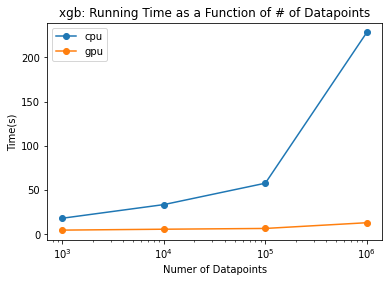

In [ ]:
# plotting xgb
plt.plot(x_vals, y_xgb_cpu_vals, '-o')
plt.plot(x_vals, y_xgb_gpu_vals, '-o')
# settings
plt.title('xgb: Running Time as a Function of # of Datapoints')
plt.ylabel('Time(s)')
plt.xlabel('Numer of Datapoints')
plt.xscale('log')
plt.legend(['cpu', 'gpu'])
plt.savefig('XGB_E1_Result')

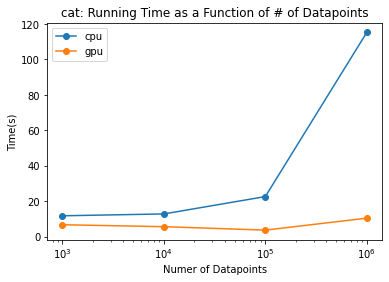

In [ ]:
# plotting cat
plt.plot(x_vals, y_cat_cpu_vals, '-o')
plt.plot(x_vals, y_cat_gpu_vals, '-o')
# settings
plt.title('cat: Running Time as a Function of # of Datapoints')
plt.ylabel('Time(s)')
plt.xlabel('Numer of Datapoints')
plt.xscale('log')
plt.legend(['cpu', 'gpu'])
plt.savefig('CAT_E1_Result')

# Experiment 2: Running Time as a Function of # of Features

In [ ]:
num_features = [20, 50, 100, 200]
fixed_num_rows = 500000 # 500k
result_dfs2 = []

for num_feature in num_features:
  print(f'***** For {num_feature} Features on Synthetic Dataset *****')
  experiment_2 = Experiment(get_synthetic_regression, "Synthetic", "Regression", "RMSE")

  # **** START parser ****
  parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
  parser.add_argument('--rows', type=int, default=fixed_num_rows,
                      help='Max rows to benchmark for each dataset.')
  parser.add_argument('--num_rounds', type=int, default=500, help='Boosting rounds.')
  parser.add_argument('--datasets', default='Synthetic,', help='Datasets to run.')
  parser.add_argument('--debug_verbose', type=int, default=1)
  parser.add_argument('--n_gpus', type=int, default=-1)
  parser.add_argument('--algs', default='xgb-cpu-hist,xgb-gpu-hist,lightgbm-cpu,lightgbm-gpu,'
                                          'cat-cpu,cat-gpu', help='Boosting algorithms to run.')
  # **** END parser ****

  args = parser.parse_args('')
  df = pd.DataFrame()
  experiment_2.run(df, args, n_feat=num_feature)
  
  result_dfs2.append(df)


### Raw Results Table

In [ ]:
dataframes2 = [result_dfs2[0], result_dfs2[1], result_dfs2[2], result_dfs2[3]]
titles2 = ['20 features', '50 features', '100 features', '200 features']
display_side_by_side(dataframes2, titles2)

,"('Synthetic', 'Time(s)')","('Synthetic', 'RMSE')",Synthetic,Time(s)
xgb-cpu-hist,nan,15.423063,36.879422,36.879422
xgb-gpu-hist,nan,15.336370,4.787061,4.787061
lightgbm-cpu,nan,15.320685,16.709877,16.709877
cat-cpu,nan,7.631316,24.541390,24.541390
cat-gpu,nan,11.504677,5.431908,5.431908
,"('Synthetic', 'Time(s)')","('Synthetic', 'RMSE')",Synthetic,Time(s)
xgb-cpu-hist,nan,12.625370,74.390640,74.390640
xgb-gpu-hist,nan,12.532856,6.596375,6.596375
lightgbm-cpu,nan,12.722733,33.341749,33.341749
cat-cpu,nan,6.467516,39.641128,39.641128


In [ ]:
cleaned_dfs2 = []
xgb_dfs2 = []
cat_dfs2 = []

# df cleanup, only retaining time(s) column and removing lightgbm-cpu as there are no gpu comparisons
for a_df in dataframes2:
  # total dfs
  clean_df2 = a_df[['Time(s)']].drop(['lightgbm-cpu'])
  cleaned_dfs2.append(clean_df2)

  # individual dfs
  xgb_df2 = clean_df2.head(2)
  cat_df2 = clean_df2.tail(2)
  xgb_dfs2.append(xgb_df2)
  cat_dfs2.append(cat_df2)

display_side_by_side(cleaned_dfs2, titles2)

,Time(s)
xgb-cpu-hist,36.879422
xgb-gpu-hist,4.787061
cat-cpu,24.541390
cat-gpu,5.431908
,Time(s)
xgb-cpu-hist,74.390640
xgb-gpu-hist,6.596375
cat-cpu,39.641128
cat-gpu,4.741777
,Time(s)


### Raw Results to excel

In [ ]:
# excel writer
writer = pd.ExcelWriter('Experiment_2_Results.xlsx')
for i in range(len(dataframes2)):
  dataframes2[i].to_excel(writer, sheet_name=titles2[i])
writer.save()

### Results Visualization

In [ ]:
# ini variables
x_vals2 = num_features
y_xgb_cpu_vals2 = []
y_xgb_gpu_vals2 = []
y_cat_cpu_vals2 = []
y_cat_gpu_vals2 = []

# creating list from dfs
for j in range(len(xgb_dfs2)):
  y_xgb_cpu_vals2.append(xgb_dfs2[j].iloc[0].at['Time(s)'])
  y_xgb_gpu_vals2.append(xgb_dfs2[j].iloc[1].at['Time(s)'])
  y_cat_cpu_vals2.append(cat_dfs2[j].iloc[0].at['Time(s)'])
  y_cat_gpu_vals2.append(cat_dfs2[j].iloc[1].at['Time(s)'])

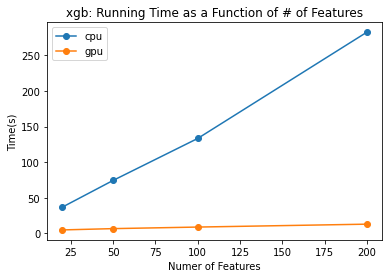

In [ ]:
# plotting xgb
plt.plot(x_vals2, y_xgb_cpu_vals2, '-o')
plt.plot(x_vals2, y_xgb_gpu_vals2, '-o')
# settings
plt.title('xgb: Running Time as a Function of # of Features')
plt.ylabel('Time(s)')
plt.xlabel('Number of Features')
plt.legend(['cpu', 'gpu'])
plt.savefig('XGB_E2_Result')

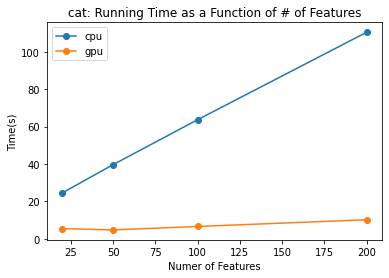

In [ ]:
# plotting cat
plt.plot(x_vals2, y_cat_cpu_vals2, '-o')
plt.plot(x_vals2, y_cat_gpu_vals2, '-o')
# settings
plt.title('cat: Running Time as a Function of # of Features')
plt.ylabel('Time(s)')
plt.xlabel('Number of Features')
plt.legend(['cpu', 'gpu'])
plt.savefig('CAT_E2_Result')

# Experiment 3:
Ablation Study with xgb-gpu-hist alg forced to make predictions on the cpu


In [ ]:
def configure_xgboost(data, use_gpu, args, cpu_pred):
    params = {'max_depth': max_depth,
              'learning_rate': learning_rate, 'n_gpus': args.n_gpus, 'min_split_loss': min_split_loss,
              'min_child_weight': min_weight, 'alpha': l1_reg, 'lambda': l2_reg, 'debug_verbose':args.debug_verbose}
    if cpu_pred:
        params['predictor'] = 'cpu_predictor'
    if use_gpu:
        params['tree_method'] = 'gpu_hist'
        # params['predictor'] = 'cpu_predictor'
    else:
        params['tree_method'] = 'hist'

    if data.task == "Regression":
        params["objective"] = "reg:linear"
        if use_gpu:
            params["objective"] = "gpu:" + params["objective"]

    elif data.task == "Multiclass classification":
        params["objective"] = "multi:softmax"
        params["num_class"] = np.max(data.y_test) + 1
    elif data.task == "Classification":
        params["objective"] = "binary:logistic"
        if use_gpu:
            params["objective"] = "gpu:" + params["objective"]
    else:
        raise ValueError("Unknown task: " + data.task)

    return params


def run_xgboost(data, params, args):
    dtrain = xgb.DMatrix(data.X_train, data.y_train)
    dval = xgb.DMatrix(data.X_val, data.y_val)
    dtest = xgb.DMatrix(data.X_test, data.y_test)
    start = time.time()
    bst = xgb.train(params, dtrain, args.num_rounds, [(dtrain, "train"), (dval, "val")])
    elapsed = time.time() - start
    pred = bst.predict(dtest)
    metric = eval(data, pred)
    return elapsed, metric


def train_xgboost(alg, data, df, args, cpu_pred=False):
    if alg not in args.algs:
        return
    use_gpu = True if 'gpu' in alg else False
    params = configure_xgboost(data, use_gpu, args, cpu_pred)
    elapsed, metric = run_xgboost(data, params, args)
    add_data(df, alg, data, elapsed, metric)


class Experiment:
    def __init__(self, data_func, name, task, metric):
        self.data_func = data_func
        self.name = name
        self.task = task
        self.metric = metric

    def run(self, df, args, n_feat=None):
        # modifying code here because I dont want to add a num_features section for all the getter functions
        if n_feat is None:
          X, y = self.data_func(num_rows=args.rows)
        else:
          X, y = self.data_func(num_rows=args.rows, num_features=n_feat)
        data = Data(X, y, self.name, self.task, self.metric)
        # train_xgboost('xgb-cpu-hist', data, df, args)
        train_xgboost('xgb-gpu-hist-cpu-pred', data, df, args, cpu_pred=True)
        # train_xgboost('xgb-gpu-hist', data, df, args, cpu_pred=False)
        # train_lightgbm('lightgbm-cpu', data, df, args)
        # train_lightgbm('lightgbm-gpu', data, df, args)
        # train_catboost('cat-cpu', data, df, args)
        # train_catboost('cat-gpu', data, df, args)
        del X
        del y
        del data


experiments = [
    Experiment(get_year, "YearPredictionMSD", "Regression", "RMSE"),
    Experiment(get_synthetic_regression, "Synthetic", "Regression", "RMSE"),
    Experiment(get_higgs, "Higgs", "Classification", "Accuracy"),
    Experiment(get_cover_type, "Cover Type", "Multiclass classification", "Accuracy"),
    # Experiment(get_bosch, "Bosch", "Classification", "Accuracy"),
    # Experiment(get_airline, "Airline", "Classification", "Accuracy"),
]

all_dataset_names = ''
for exp in experiments:
    all_dataset_names += exp.name + ','
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--rows', type=int, default=None,
                    help='Max rows to benchmark for each dataset.')
parser.add_argument('--num_rounds', type=int, default=500, help='Boosting rounds.')
parser.add_argument('--datasets', default=all_dataset_names, help='Datasets to run.')
parser.add_argument('--debug_verbose', type=int, default=1)
parser.add_argument('--n_gpus', type=int, default=-1)
parser.add_argument('--algs', default='xgb-cpu-hist,xgb-gpu-hist, xgb-gpu-hist-cpu-pred,lightgbm-cpu,lightgbm-gpu,'
                                        'cat-cpu,cat-gpu', help='Boosting algorithms to run.')
args = parser.parse_args('')
df = pd.DataFrame()
for exp in experiments:
    if exp.name in args.datasets:
        exp.run(df, args)
        # Write partial results at each iteration in case of failure
        print(df.to_string())
        write_results(df, "results.latex", "latex")
        write_results(df, "results.csv", "csv")